
# Пример ARIMA для TL Sales

In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline

In [2]:
# stat packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

In [3]:
import seaborn as sns 
sns.set_style("whitegrid")
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [4]:
from pyramid.arima import auto_arima, ARIMA as pARIMA

In [6]:
# просмотр всех CSV-файлов в текущей папке
!dir /b *.csv

altair-data-0002fb89f3a9c86709fb46f7ad98de19.csv
altair-data-0c150113757903c1f764306ab9935e5d.csv
altair-data-11a41719a553acb316c24c22e8591e92.csv
altair-data-1cb65ffe62f9f04b5a04f6bfe5999b98.csv
altair-data-20ec790f128b237d2dc3d27e332471e7.csv
altair-data-4ed04a171f2d535fe5ca5d045a858dcf.csv
altair-data-5aabad99a38e7aa86d1651c20b630f15.csv
altair-data-609d16495dcefea569797cbf937297a8.csv
altair-data-6adb7a653a000283f864760e3852a65a.csv
altair-data-6d208bb08d56bed0199865475245a27e.csv
altair-data-8b83faf6692910a0f750738ebaced499.csv
altair-data-8b84098a5963279e570a7c7055d74d5f.csv
altair-data-bc2fc5550bb38051153f64ca366ab0da.csv
altair-data-e8a863afb2759848b2625406b32a1247.csv
altair-data-ec857f5752e7a2da6a356ef869932fc7.csv
altair-data-f17cab87058a44ea4415eb3e6895634c.csv
history_test.csv
order_test.csv
TL_Sales.csv
tvf_get_order_book_snapshots 15.09.2018-01.10.2018.csv


In [8]:
# загрузка в датафрейм
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv("TL_Sales.csv", delimiter=";", index_col='DATE', date_parser=dateparse)
sales_df.index = pd.to_datetime(sales_df.index)

In [9]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3637 entries, 2008-01-09 to 2019-08-30
Data columns (total 2 columns):
Sales        3343 non-null float64
Forecast0    871 non-null float64
dtypes: float64(2)
memory usage: 85.2 KB


In [10]:
sales_df.tail()

,Sales,Forecast0
DATE,,
2019-08-26,NaN,329291.53
2019-08-27,NaN,329291.53
2019-08-28,NaN,329291.53
2019-08-29,NaN,329291.53
2019-08-30,NaN,329291.53


In [11]:
def plot_Sales(x):
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.plot(x, marker='.', color='red', linestyle='-', linewidth=2, markerfacecolor='r')
    plt.show()

## Группировка по месяцам

In [12]:
sales_by_month = sales_df.Sales.resample('M').sum()
sales_by_month.head()

DATE
2008-01-31    4947364.96
2008-02-29    5899044.51
2008-03-31    6933912.13
2008-04-30    6929039.09
2008-05-31    6102179.36
Freq: M, Name: Sales, dtype: float64

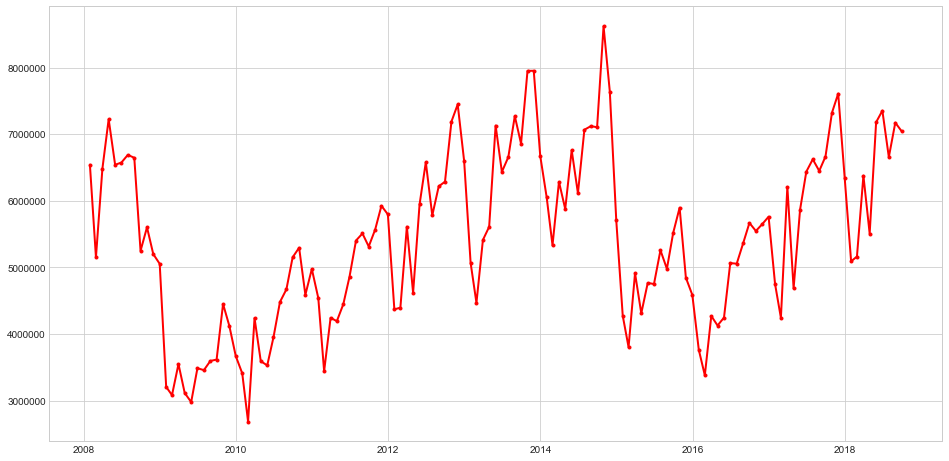

In [12]:
plot_Sales(sales_by_month['2008-01-01':'2018-10-01'])

## Графики автокорреляции

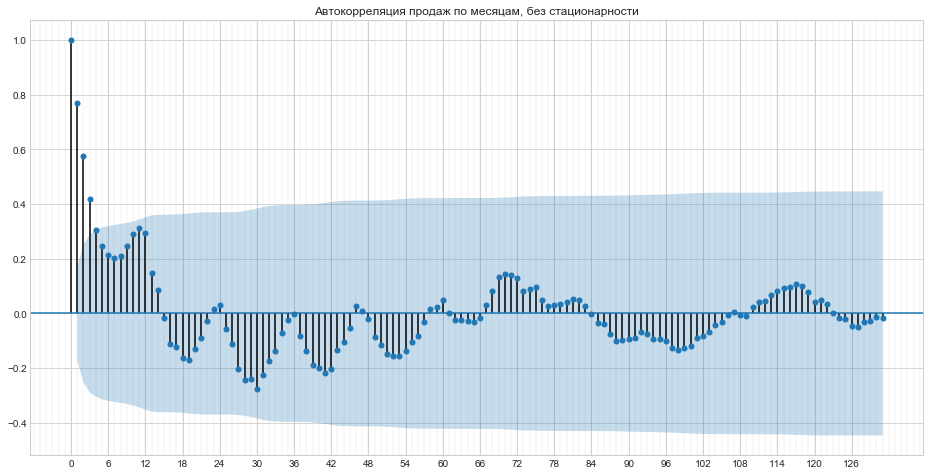

In [14]:
plt.rcParams['figure.figsize'] = [16, 8]

ax = plt.gca()
plt.xticks(np.arange(0, len(sales_by_month), step=6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

_ = plot_acf(sales_by_month, 
             title="Автокорреляция продаж по месяцам, без стационарности", 
             alpha=0.05, ax=ax)

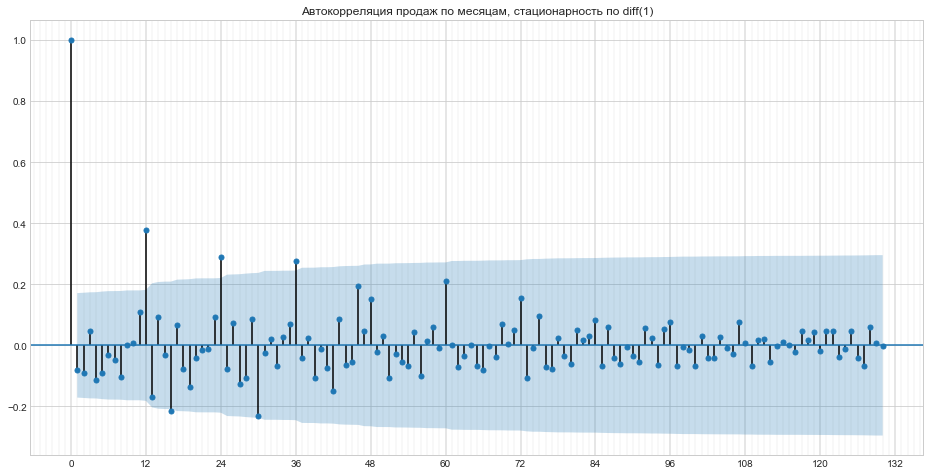

In [101]:
plt.rcParams['figure.figsize'] = [16, 8]
ax = plt.gca()
plt.xticks(np.arange(0, len(sales_by_month), step=6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(12))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)
ax.xaxis.grid(which='major', color='gray', linewidth=0.3)

_ = plot_acf(sales_by_month.diff().dropna(), 
             title="Автокорреляция продаж по месяцам, стационарность по diff(1)", 
             alpha=0.05, ax=ax)

На графике видны годовые корреляции, которые отмечены линиями каждые 12 интервалов

## Расчёт значений автокорреляций

In [16]:
autocorrelation = sales_by_month.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(sales_by_month))
print(f"Автокорреляция между соседними месяцами = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция между соседними месяцами = 79.06%
Приблизительный доверительный интервал = +/- 0.1706


Делаю pct_change с лагом 12, который был обнаружен на предыдущем графике

In [17]:
autocorrelation = sales_by_month.pct_change(12).autocorr()
confidence = 1.96 / np.sqrt(len(sales_by_month.pct_change(12)))
print(f"Автокорр. pct_change(12) между аналогичными периодами разных годов = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорр. pct_change(12) между аналогичными периодами разных годов = 83.14%
Приблизительный доверительный интервал = +/- 0.1706


Автокорреляция 83.14%, что даже больше, чем на соседних значениях с лагом 1

## Разбивка на train/test

In [105]:
df = sales_by_month
start_date, split_date, end_date = '2015-01-31', '2018-01-31', '2018-09-30'
starting = len(df[:start_date]) 
split_point = len(df[:split_date]) # 7 лет
ending = len(df[:end_date]) 
print(f"starting period={starting}, split point={split_point}, ending period={ending}")

starting period=85, split point=121, ending period=129


In [106]:
train = df.iloc[starting:split_point]
test = df.iloc[split_point-1:ending]

In [107]:
print(f"Исходный размер={len(df)}rows, train={len(train)}rows, test={len(test)}rows")

Исходный размер=132rows, train=36rows, test=9rows


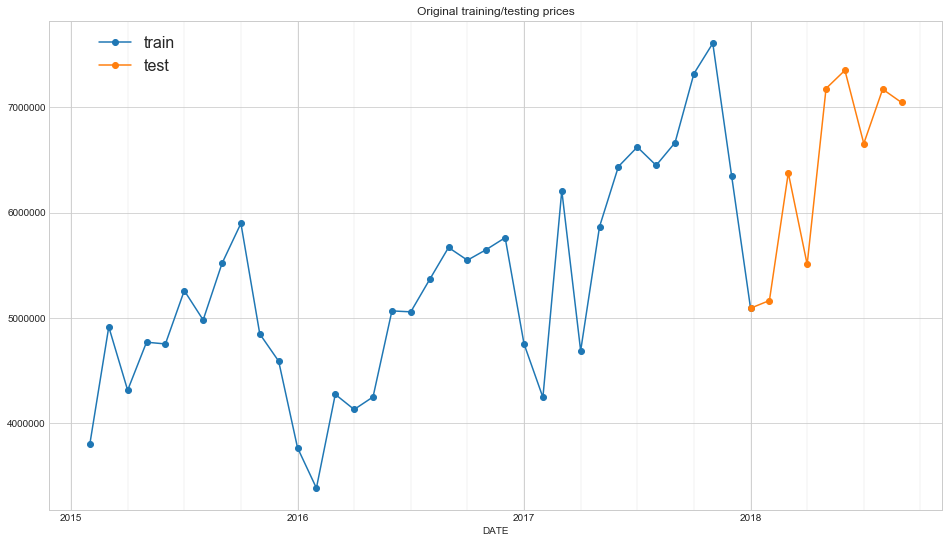

In [108]:
plt.rcParams['figure.figsize'] = [16, 9]
#fig, ax = plt.subplots()
ax = plt.gca()

plt.xticks(np.arange(0, len(sales_by_month), step=1))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

ax.grid(True, which='both')

train.plot(ax=ax, marker='o', title="Original training/testing prices")
test.plot(ax=ax, marker='o')

ax.legend(['train', 'test'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))

plt.show()

## Pyramid Auto-ARIMA

In [109]:
fit = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                 start_P=0, seasonal=True, d=1, D=1, trace=True,
                 stationarity=True, 
                 out_of_sample_size=0, #len(test),
                 error_action='ignore',  # don't want to know if an order does not work
                 suppress_warnings=True,  # don't want convergence warnings
                 stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=686.938, BIC=689.209, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=687.435, BIC=691.977, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=687.287, BIC=690.694, Fit time=0.040 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=688.230, BIC=691.637, Fit time=0.019 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=689.945, BIC=693.352, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=na

In [110]:
print(fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -341.469
Date:                            Mon, 15 Oct 2018   AIC                            686.938
Time:                                    21:01:08   BIC                            689.209
Sample:                                         0   HQIC                           687.510
                                             - 36                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.312e+04   1.43e+05      0.232      0.817   -2.47e+05    3.14e+05
sigma2      4.603e+11   1.51e+11   

In [111]:
# делаем предсказания на 24 мес вперёд
forecast_horizon = 24
predictions = fit.predict(n_periods=forecast_horizon)

In [112]:
prediction_range = pd.date_range(start=test.index[0], periods=forecast_horizon, freq='M')

In [113]:
# строим прогноз
forecast = pd.DataFrame(list(zip(prediction_range, predictions)), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

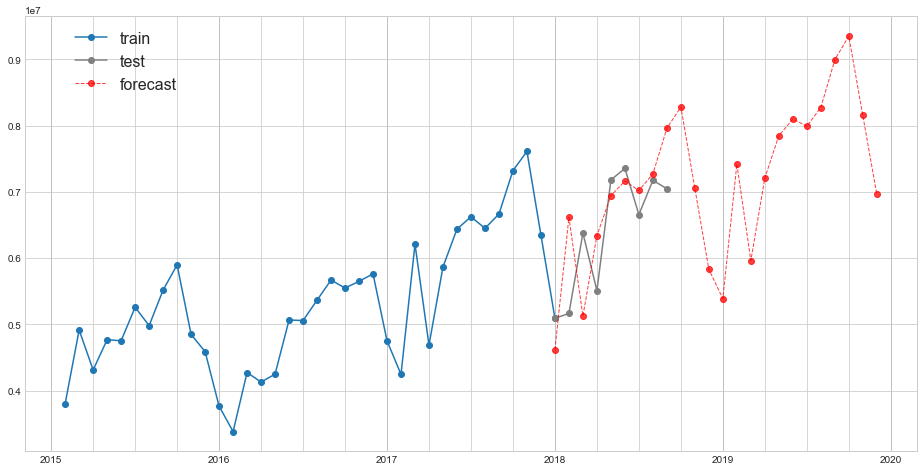

In [114]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.grid(True, which='minor', linestyle='-')
ax.grid(True, which='major', axis='x', color='gray', linewidth=0.8)

train.plot(ax=ax, marker='o')
test.plot(color='gray', ax=ax, marker='o')
forecast.plot(color='red', linewidth=1, linestyle='--', marker='o', alpha=0.75, ax=ax)

ax.legend(['train', 'test', 'forecast'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

In [115]:
pd.options.display.float_format = '${:,.0f}'.format
pd.DataFrame({'forecast':forecast, 'actual':test})

,forecast,actual
2018-01-31,"$4,616,797","$5,091,439"
2018-02-28,"$6,615,485","$5,164,149"
2018-03-31,"$5,125,524","$6,377,590"
2018-04-30,"$6,338,758","$5,508,194"
2018-05-31,"$6,942,780","$7,179,376"
2018-06-30,"$7,161,476","$7,352,336"
2018-07-31,"$7,020,384","$6,656,089"
2018-08-31,"$7,269,384","$7,172,797"
2018-09-30,"$7,958,314","$7,046,423"
2018-10-31,"$8,279,970",$nan


## StatModels SARIMAX

In [ ]:
fit_sarimax = SARIMAX(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                 start_P=0, seasonal=True, d=1, D=1, trace=True,
                 stationarity=True, 
                 out_of_sample_size=0, #len(test),
                 error_action='ignore',  # don't want to know if an order does not work
                 suppress_warnings=True,  # don't want convergence warnings
                 stepwise=True)  # set to stepwise